# Bagging rankers demo

In [1]:
from PrepareData import prepare_data
from lightgbm.sklearn import LGBMRanker
from sklearn.naive_bayes import GaussianNB
from rankers.Bagger import Bagger
from rankers.Ranker import Ranker
import numpy as np
import pandas as pd
from Evaluations import get_evaluation_plots


In [2]:
train, test, train_baskets, bestsellers_previous_week, test_week_transactions = prepare_data(kaggle_submission=False)

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1


In [3]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [4]:
test_X = test[columns_to_use]

for LGBM ranker, when splitting data for bagger, need to recompute the train baskets based on the subset - just regroup the data in the same way as in PrepareData

In [5]:
lgbm_ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=0
)

In [6]:
#gnb_ranker = Ranker(GaussianNB())

In [7]:
#bagger = Bagger(lgbm_ranker, nr_rankers=10, samples_proportion=0.3)

In [8]:
#fitting rankers
#bagger = bagger.fit(train, columns_to_use, use_groups=True)


In [9]:
#predicting with rankers
#preds = bagger.predict(test_X)

In [10]:
#test['preds'] = preds

In [11]:
nr_rankers_range = [1, 7, 15]
#samples_proportion_range = np.arange(0.1, 1.1, 0.1)
samples_proportion_range = [0.33, 0.66, 1]
preds_cols = []

In [12]:
#training new bagger for each combination of nr_rankers and samples_proportion and recording results
for nr in nr_rankers_range:
    print(f"Testing with {nr} rankers")
    for sp in samples_proportion_range:
        print(f"  Testing with {sp} of training data for each ranker.")

        bagger = Bagger(lgbm_ranker, nr, sp)
        bagger = bagger.fit(train, columns_to_use, use_groups=True)
        pred_name = f"{nr}Rankers-{sp}Prop"
        preds_cols.append(pred_name)
        test[pred_name] = bagger.predict(test_X)
        


Testing with 1 rankers
  Testing with 0.33 of training data for each ranker.
  Testing with 0.66 of training data for each ranker.
  Testing with 1 of training data for each ranker.
Testing with 7 rankers
  Testing with 0.33 of training data for each ranker.
  Testing with 0.66 of training data for each ranker.
  Testing with 1 of training data for each ranker.
Testing with 15 rankers
  Testing with 0.33 of training data for each ranker.
  Testing with 0.66 of training data for each ranker.
  Testing with 1 of training data for each ranker.


Evaluation for 1Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011459593464056188
MAP@12 (only purchasing customers): 0.02279127484752378

MRR (all customers):                0.00217400297401464
MRR (only purchasing customers):    0.043237397081766875



Evaluation for 1Rankers-0.66Prop
####################

MAP@12 (all customers):             0.0011541996721869039
MAP@12 (only purchasing customers): 0.022955161577278626

MRR (all customers):                0.0022049769729582834
MRR (only purchasing customers):    0.04385341974021956



Evaluation for 1Rankers-1Prop
####################

MAP@12 (all customers):             0.0011685310245055955
MAP@12 (only purchasing customers): 0.023240188956876767

MRR (all customers):                0.0022178901046668894
MRR (only purchasing customers):    0.04411024100952219



Evaluation for 7Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011517725859111886
MAP@12 (only purchasing cust

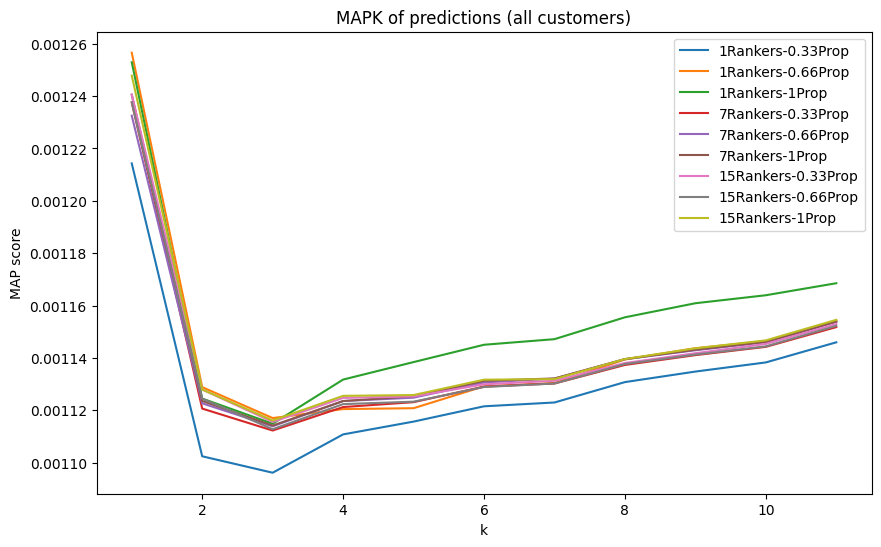

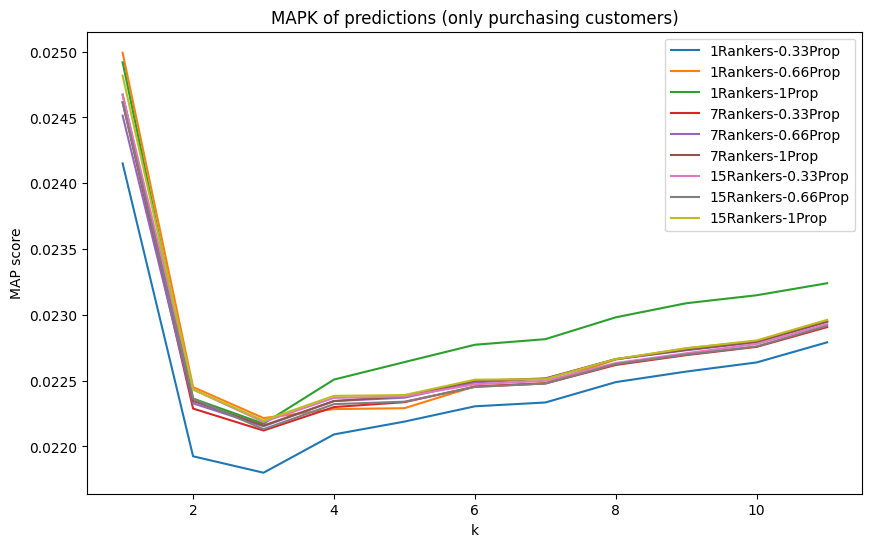

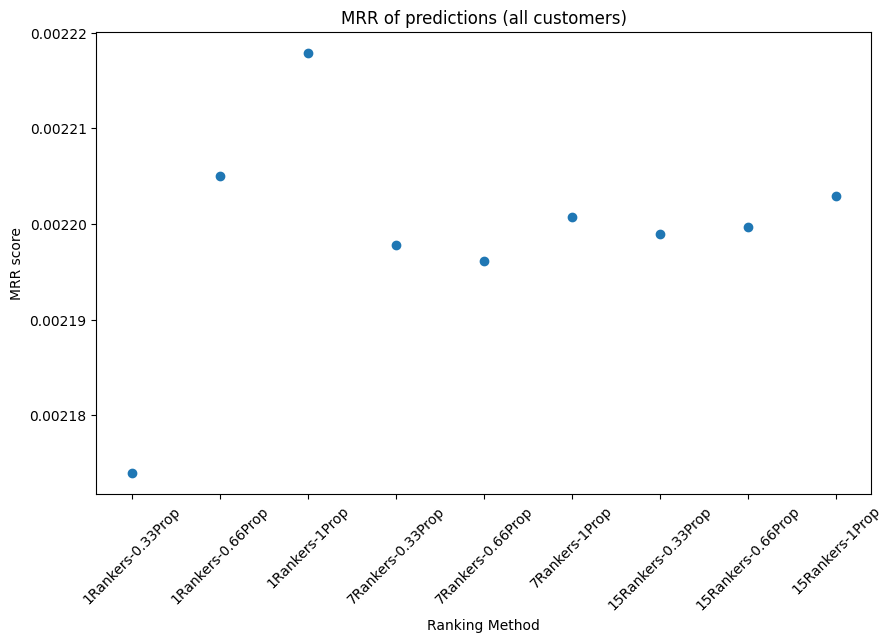

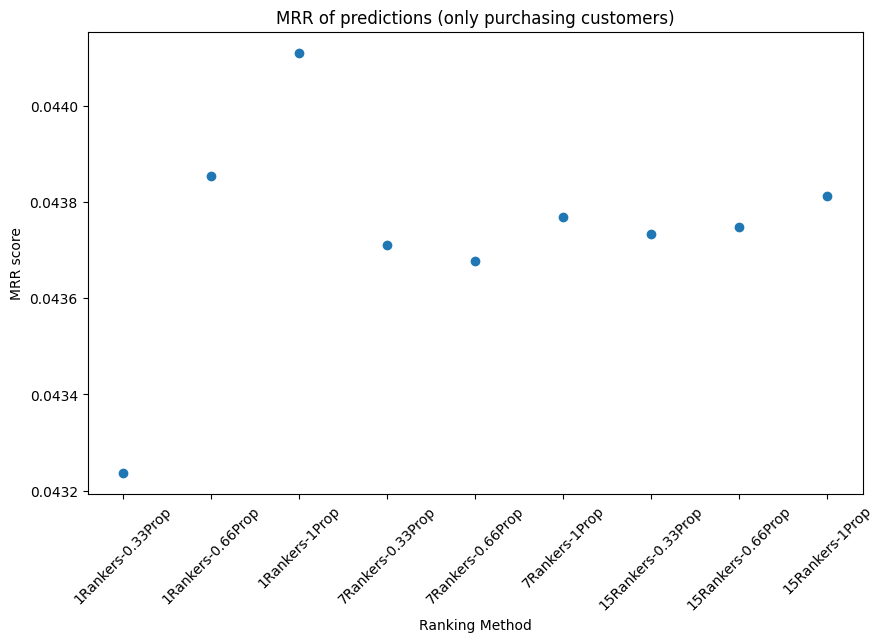

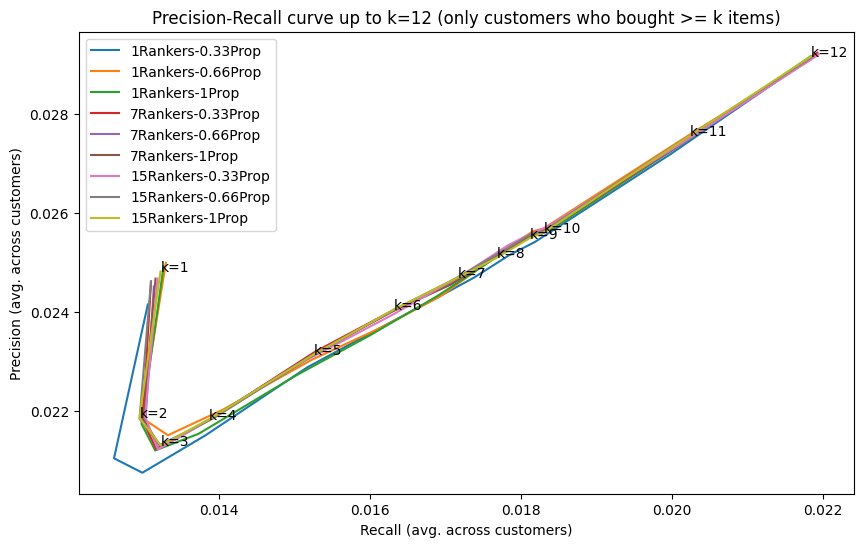

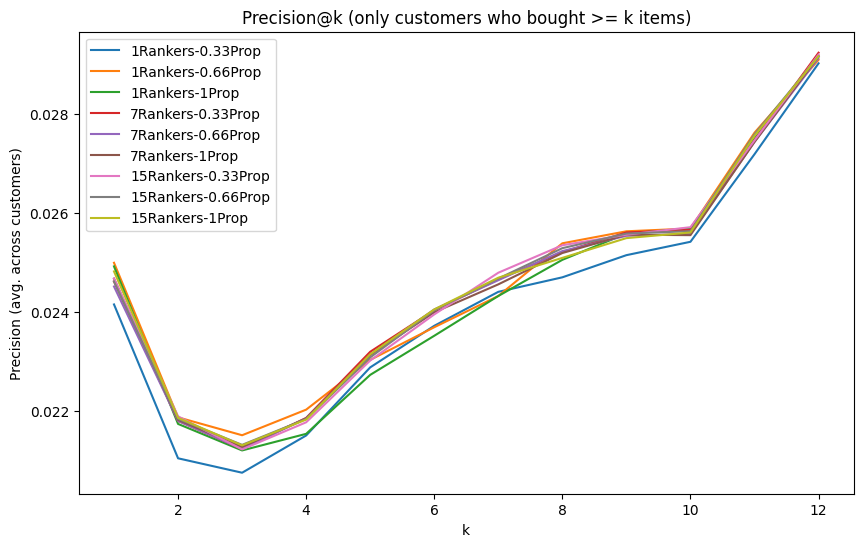

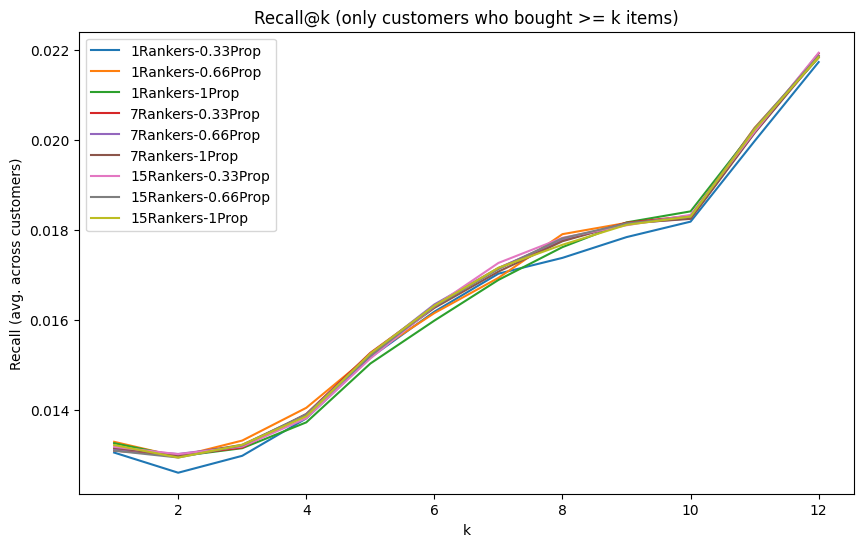

In [13]:
mapk_per_col, mapk_per_col_dense, mrr_per_col, mrr_per_col_dense, pr_curves_dense = get_evaluation_plots(test, preds_cols, test_week_transactions, bestsellers_previous_week)